<a href="https://colab.research.google.com/github/Maansi-1590/Aerial-Object-Project/blob/main/Aerial_Object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ▣ Check GPU
!nvidia-smi

# ▣ Install Required Libraries
!pip install tensorflow keras matplotlib seaborn scikit-learn
!pip install ultralytics
!pip install streamlit

/bin/bash: line 1: nvidia-smi: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dataset_path = "/content/drive/MyDrive/classification_dataset-20251124T102657Z-1-001/"

In [10]:
!ls $dataset_path

classification_dataset


In [11]:
dataset_path = "/content/drive/MyDrive/classification_dataset-20251124T102657Z-1-001/classification_dataset/"

In [12]:
!ls $dataset_path

test  train  valid


In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # important for evaluation
)

Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.


In [14]:
print(train_ds.class_names)

['bird', 'drone']


In [37]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Build a custom CNN Model

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze pretrained layers initially

model = models.Sequential([
    data_augmentation,                # ⚠️ Add augmentation here
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30,  # longer because using pretrained backbone
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.7491 - loss: 0.6045 - val_accuracy: 0.9480 - val_loss: 0.1416
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9053 - loss: 0.2324 - val_accuracy: 0.9570 - val_loss: 0.1144
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9250 - loss: 0.1996 - val_accuracy: 0.9593 - val_loss: 0.1100
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9322 - loss: 0.1689 - val_accuracy: 0.9615 - val_loss: 0.1083
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9422 - loss: 0.1498 - val_accuracy: 0.9615 - val_loss: 0.1082
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9468 - loss: 0.1307 - val_accuracy: 0.9638 - val_loss: 0.1037
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9532 - loss: 0.1402 - val_accuracy: 0.9661 - val_loss: 0.1003
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9549 - loss: 0.1099 - val_accuracy: 0.9661 - v

In [40]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9779 - loss: 0.0544
Test Accuracy: 0.9720930457115173


In [41]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels directly
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Get predicted labels
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Confusion Matrix:
[[119   2]
 [  4  90]]
Classification Report:
              precision    recall  f1-score   support

        bird       0.97      0.98      0.98       121
       drone       0.98      0.96      0.97        94

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215



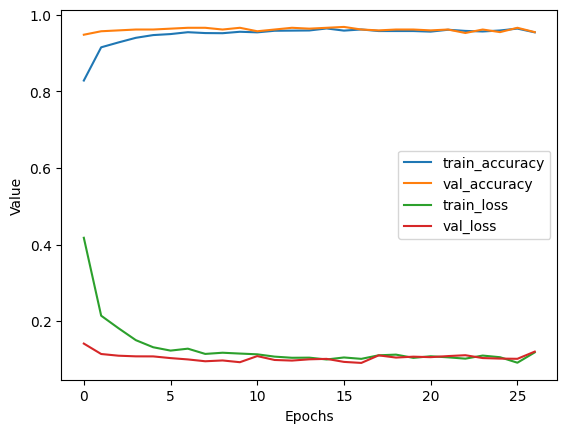

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [43]:
# The 'model' object from the training cell (qbnuhRKMp9yj) should still be in memory
# if the kernel has not been reset since training finished.
# We will directly save this in-memory model to Google Drive.
# This bypasses loading 'best_model.h5', which was causing a FileNotFoundError.

model.save("/content/drive/MyDrive/aerial_classification_model.keras")

In [44]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/aerial_classification_model.keras")


In [45]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9779 - loss: 0.0544
Test Accuracy: 0.9720930457115173


In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Convert true labels to NumPy arrays
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Predicted probabilities
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Confusion Matrix:
[[119   2]
 [  4  90]]
Classification Report:
              precision    recall  f1-score   support

        bird       0.97      0.98      0.98       121
       drone       0.98      0.96      0.97        94

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


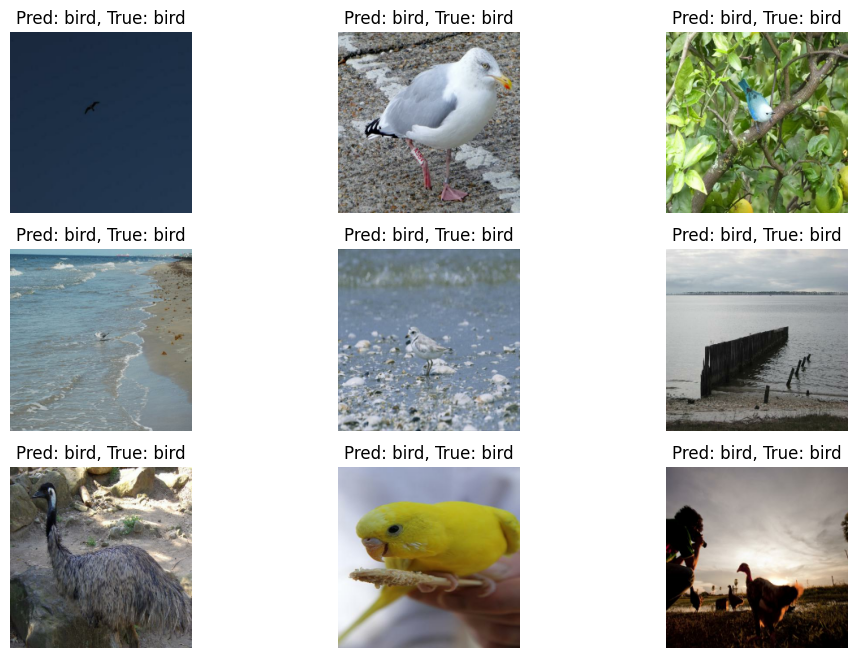

In [47]:
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)
    plt.figure(figsize=(12,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {train_ds.class_names[preds[i]]}, True: {train_ds.class_names[labels[i]]}")
        plt.axis("off")
    plt.show()

In [48]:
!pip install streamlit

In [58]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# -----------------------------
# ⚙️ Load Model
# -----------------------------
MODEL_PATH ="/content/drive/MyDrive/aerial_classification_model.keras"
model = load_model(MODEL_PATH)

CLASS_NAMES = ["Bird", "Drone"]

# -----------------------------
# 📌 Prediction Function
# -----------------------------
def classify_image(image):

    img = image.resize((224, 224))  # Resize to model input
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    class_id = np.argmax(prediction)
    confidence = float(np.max(prediction))

    return CLASS_NAMES[class_id], confidence


# -----------------------------
# 🎨 Streamlit UI
# -----------------------------
st.set_page_config(page_title="Bird vs Drone Classifier", layout="centered")

st.title("🦅 Bird vs Drone Classification")
st.write("Upload an image to classify whether it contains a **Bird** or a **Drone**.")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

if uploaded_file:

    # Show uploaded image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    st.markdown("---")

    # Run classification
    if st.button("Classify Image"):
        label, confidence = classify_image(image)

        st.success(f"**Prediction:** {label}")
        st.info(f"**Confidence:** {confidence * 100:.2f}%")

else:
    st.info("Please upload an image to start.")

Overwriting app.py


In [59]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2025-11-29 12:50:05--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-11-29 12:50:05--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-29T13%3A41%3A13Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-

In [60]:
!streamlit run /content/app.py &>/content/logs.txt &

In [61]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://tribes-fascinating-detroit-procurement.trycloudflare.com
